# Option Pricing with BasePricer and MCPricer

This notebook demonstrates how to use the `BasePricer` and `MCPricer` classes to price options with different volatility models, including:
1. Local volatility models
2. Path-dependent volatility (PDV) models

We'll walk through setting up the models, configuring the pricers, and calculating option prices and Greeks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import our pricer and model classes
from base_model import BaseModel
from MCPricer import MCPricer
from pdv_model import PDVModel

from BScalculator import *

## Forward Start Options

A forward start option is an option that begins at some future time (the "start time"), with a strike price that is determined at that future time based on the market price of the underlying asset at the start time. Typically, the strike price is set as a percentage of the underlying's price at the start time.

In this demo, we will:
1. Define a simple local volatility model (flat at 0.2)
2. Set up both local volatility and PDV models
3. Price a forward start option using both models
4. Compare results and visualize price paths

In [2]:
# Define a simple local volatility model with flat vol
class FlatLocalVolModel(BaseModel):
    """
    A simple local volatility model with a constant volatility across all strikes and expiries
    """
    def __init__(self, s0: float, volatility: float = 0.2, dt: float = 1/252):
        super().__init__(s0, 0.0, x_dimensions=1)  # x0 not used for this model
        self.volatility = volatility
        self.dt = dt
        
    def sigma(self, t: float, S: np.ndarray, X: np.ndarray) -> np.ndarray:
        """Return constant volatility regardless of state"""
        return np.full_like(S, self.volatility, dtype=float)
    
    def dupire_vol(self, t: float, S: np.ndarray) -> np.ndarray:
        """Return flat local volatility surface"""
        return np.full_like(S, self.volatility, dtype=float)
    
    def update_X(self, t: float) -> np.ndarray:
        """No state variables to update in this model"""
        return np.zeros(1)  # Return dummy value as this model doesn't use X

In [3]:
# Set up common parameters
S0 = 100.0  # Initial stock price
risk_free_rate = 0.0  # 3% risk-free rate
dividend_yield = 0.0  # 1% dividend yield
dt = 1/252  # Daily time steps (252 trading days per year)
flat_vol = 0.2  # 20% flat volatility

# Initialize our models
flat_vol_model = FlatLocalVolModel(S0, volatility=flat_vol, dt=dt)

# Initialize PDV model with the same flat local vol component
pdv_model = PDVModel(
    s0=S0, 
    x0=S0,  # Initialize X0 to S0 for VWAP
    dt=dt,
    Delta=1/12,  # 1 month lookback for PDV
    kappa=0.8,  # Mean reversion strength
    sigma0=flat_vol,  # Base volatility
    X_type='VWAP',  # Use volume weighted average price as the path-dependent factor
    sigma_type=1,  # Simple sigma model
    dupire_vol_interp=lambda t, s: np.full_like(s, flat_vol, dtype=float)  # Use flat vol
)

print(f"Models initialized with S0={S0}, flat vol={flat_vol}")
print(f"Risk-free rate: {risk_free_rate*100:.1f}%, Dividend yield: {dividend_yield*100:.1f}%")

Models initialized with S0=100.0, flat vol=0.2
Risk-free rate: 0.0%, Dividend yield: 0.0%


In [4]:
# Set up Monte Carlo simulation parameters
num_paths = 100_000  # Number of paths for final simulation
num_particles = 50_000  # Number of particles for leverage calibration (only used in PDV model)
time_steps = 252  # Number of time steps (1 year of trading days)

# Initialize Monte Carlo pricers
mc_flat_vol = MCPricer(
    model=flat_vol_model,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield,
    use_antithetic=False,  # No antithetic variates for this demo
    rng=np.random.default_rng(42)  # Set seed for reproducibility
)

mc_pdv = MCPricer(
    model=pdv_model,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield,
    use_antithetic=False,
    rng=np.random.default_rng(42)  # Use same seed for fair comparison
)

# Set up the flat local vol simulation
mc_flat_vol.setup_simulation(
    num_paths=num_paths, 
    time_steps=time_steps, 
    dt=dt,
    use_local_vol_simulator=True  # Explicitly use LocalVolSimulator
)
mc_flat_vol.run_simulation()

# Set up the PDV model simulation
mc_pdv.setup_simulation(
    num_paths=num_paths,  # This is used for the final simulation
    time_steps=time_steps, 
    dt=dt,
    use_local_vol_simulator=False  # Use ParticleMonteCarlo for PDV
)
mc_pdv.run_simulation()

print()

Using LocalVolSimulator for local volatility model
Simulating Local Volatility Model
Using ParticleMonteCarlo for path-dependent volatility model
Simulating PDVModel
Using 10000 particles to initialize leverage surface



In [5]:
# Define forward start option parameters
option_types = ['call', 'put']
strike_percentages = [0.95, 1.05]  # Strikes at 95% and 105% of forward price
start_time = [0, 1/12, 1/6, 1/4, 1/3, 1/2]  # Start times in years (1 month, 2 months, 3 months, 4 months, 6 months)
expiry = [t + 1/12 for t in start_time]  # Expiry is 1 month after start time

print("\nPricing forward start options spread with the following parameters:")
print(f"Option types: {option_types}")
print(f"Strike percentages: {strike_percentages} (of forward price)")
print(f"Start times: {[f'{t*12:.1f} months' for t in start_time]}")
print(f"Expiries: {[f'{t*12:.1f} months' for t in expiry]}")
print(f"Spreads: {option_types[0].capitalize()} {strike_percentages[0]} - {strike_percentages[1]} and {option_types[1].capitalize()} {strike_percentages[0]} - {strike_percentages[1]}")


Pricing forward start options spread with the following parameters:
Option types: ['call', 'put']
Strike percentages: [0.95, 1.05] (of forward price)
Start times: ['0.0 months', '1.0 months', '2.0 months', '3.0 months', '4.0 months', '6.0 months']
Expiries: ['1.0 months', '2.0 months', '3.0 months', '4.0 months', '5.0 months', '7.0 months']
Spreads: Call 0.95 - 1.05 and Put 0.95 - 1.05


In [6]:
# Create dataframes to store results for both models
results = []

# Loop through all combinations of option types, strikes, and times
for opt_type in option_types:
    for idx, s_time in enumerate(start_time):
        e_time = expiry[idx]
        
        # Calculate prices for both strike percentages with flat vol model
        flat_low_price = mc_flat_vol.price_forward_start(opt_type, strike_percentages[0], s_time, e_time)
        flat_high_price = mc_flat_vol.price_forward_start(opt_type, strike_percentages[1], s_time, e_time)
        
        # Calculate spread for flat vol model
        flat_spread = flat_low_price['price'] - flat_high_price['price']
        
        # Calculate prices for both strike percentages with PDV model
        pdv_low_price = mc_pdv.price_forward_start(opt_type, strike_percentages[0], s_time, e_time)
        pdv_high_price = mc_pdv.price_forward_start(opt_type, strike_percentages[1], s_time, e_time)
        
        # Calculate spread for PDV model
        pdv_spread = pdv_low_price['price'] - pdv_high_price['price']
        
        # Store results
        results.append({
            'Option Type': opt_type.capitalize(),
            'Start Time (months)': s_time * 12,
            'Expiry (months)': e_time * 12,
            f'{strike_percentages[0]} Price (Flat Vol)': flat_low_price['price'],
            f'{strike_percentages[1]} Price (Flat Vol)': flat_high_price['price'],
            f'Spread {strike_percentages[0]}-{strike_percentages[1]} (Flat Vol)': flat_spread,
            f'{strike_percentages[0]} Price (PDV)': pdv_low_price['price'],
            f'{strike_percentages[1]} Price (PDV)': pdv_high_price['price'],
            f'Spread {strike_percentages[0]}-{strike_percentages[1]} (PDV)': pdv_spread,
            'Spread Difference (PDV - Flat)': pdv_spread - flat_spread
        })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
display(results_df)

,Option Type,Start Time (months),Expiry (months),0.95 Price (Flat Vol),1.05 Price (Flat Vol),Spread 0.95-1.05 (Flat Vol),0.95 Price (PDV),1.05 Price (PDV),Spread 0.95-1.05 (PDV),Spread Difference (PDV - Flat)
0,Call,0.0,1.0,0.055752,0.006488,0.049264,0.056013,0.006364,0.049649,0.000385
1,Call,1.0,2.0,0.055865,0.006509,0.049355,0.058404,0.003473,0.054931,0.005576
2,Call,2.0,3.0,0.055633,0.006468,0.049165,0.058470,0.002816,0.055654,0.006489
3,Call,3.0,4.0,0.055856,0.006539,0.049317,0.058804,0.002683,0.056121,0.006804
4,Call,4.0,5.0,0.055625,0.006489,0.049136,0.058777,0.002547,0.056230,0.007094
5,Call,6.0,7.0,0.056158,0.006675,0.049484,0.059088,0.002362,0.056726,0.007242
6,Put,0.0,1.0,0.005836,0.056572,-0.050736,0.006071,0.056422,-0.050351,0.000385
7,Put,1.0,2.0,0.005770,0.056415,-0.050645,0.008370,0.053439,-0.045069,0.005576
8,Put,2.0,3.0,0.005771,0.056605,-0.050835,0.008521,0.052866,-0.044346,0.006489
9,Put,3.0,4.0,0.005762,0.056445,-0.050683,0.008770,0.052649,-0.043879,0.006804


In [7]:
sigma = flat_vol  # Use the flat volatility for calculations
def func(K, T1, T2):
    d1 = (-np.log(K) + (0.5 * sigma**2) * (T2 - T1)) / (sigma * np.sqrt(T2 - T1))
    d2 = d1 - sigma * np.sqrt(T2 - T1)
    price = norm.cdf(d1) - K  * norm.cdf(d2)
    return price
print(func(0.9, 0, 1/12))
print(func(0.95, 0, 1/12))
print(func(1.05, 0, 1/12))
print(func(1.1, 0, 1/12))
print(f"spread: {func(0.95, 0, 1/12) - func(1.05, 0, 1/12)}")


0.1007339936955367
0.05577099409269992
0.006562218381839596
0.0012467892110444648
spread: 0.049208775710860325


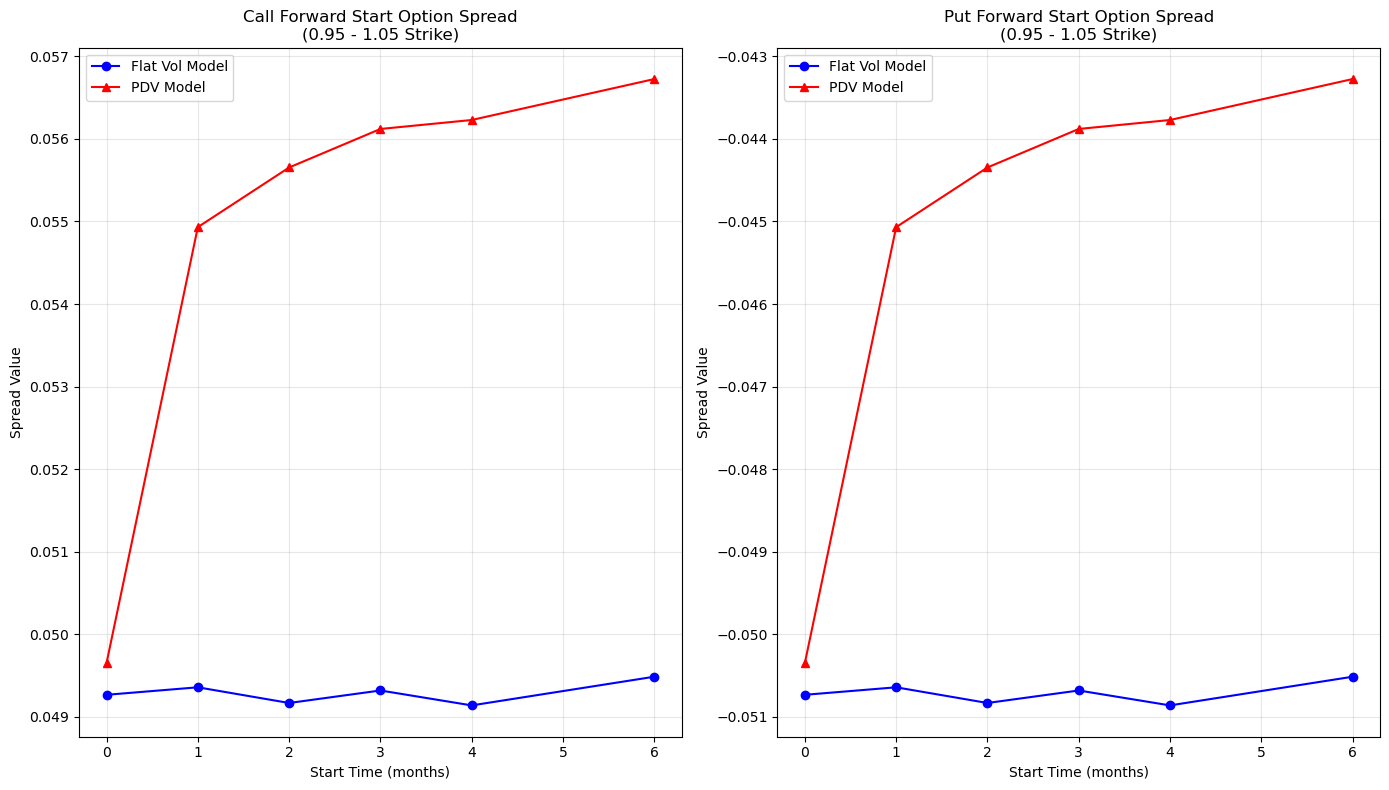

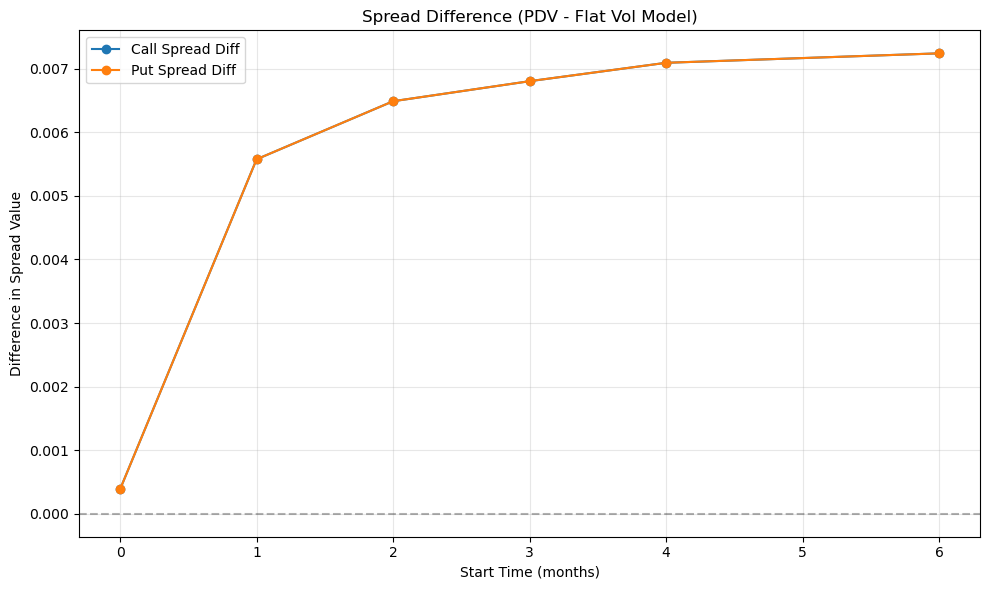

In [8]:
# Visualize the forward start option spreads
plt.figure(figsize=(14, 8))

# Plot call and put spreads side by side
for i, opt_type in enumerate(option_types):
    # Filter data for this option type
    opt_data = results_df[results_df['Option Type'] == opt_type.capitalize()]
    
    plt.subplot(1, 2, i+1)
    
    # Plot spread for flat vol and PDV models
    plt.plot(opt_data['Start Time (months)'], 
             opt_data[f'Spread {strike_percentages[0]}-{strike_percentages[1]} (Flat Vol)'], 
             'b-o', label='Flat Vol Model')
    
    plt.plot(opt_data['Start Time (months)'], 
             opt_data[f'Spread {strike_percentages[0]}-{strike_percentages[1]} (PDV)'], 
             'r-^', label='PDV Model')
    
    plt.title(f'{opt_type.capitalize()} Forward Start Option Spread\n({strike_percentages[0]} - {strike_percentages[1]} Strike)', fontsize=12)
    plt.xlabel('Start Time (months)')
    plt.ylabel('Spread Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
plt.tight_layout()
plt.show()

# Plot spread differences (PDV - Flat Vol)
plt.figure(figsize=(10, 6))

# Group by option type
for opt_type in option_types:
    opt_data = results_df[results_df['Option Type'] == opt_type.capitalize()]
    plt.plot(opt_data['Start Time (months)'], 
             opt_data['Spread Difference (PDV - Flat)'], 
             marker='o', label=f'{opt_type.capitalize()} Spread Diff')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.title('Spread Difference (PDV - Flat Vol Model)', fontsize=12)
plt.xlabel('Start Time (months)')
plt.ylabel('Difference in Spread Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Forward Volatility Smile for Vanilla Call Options

Next, we'll visualize the forward volatility smile for vanilla call options using both models:
1. The flat volatility model 
2. The path-dependent volatility (PDV) model

A forward volatility smile shows how implied volatility varies across different strikes for options that start at a future date.

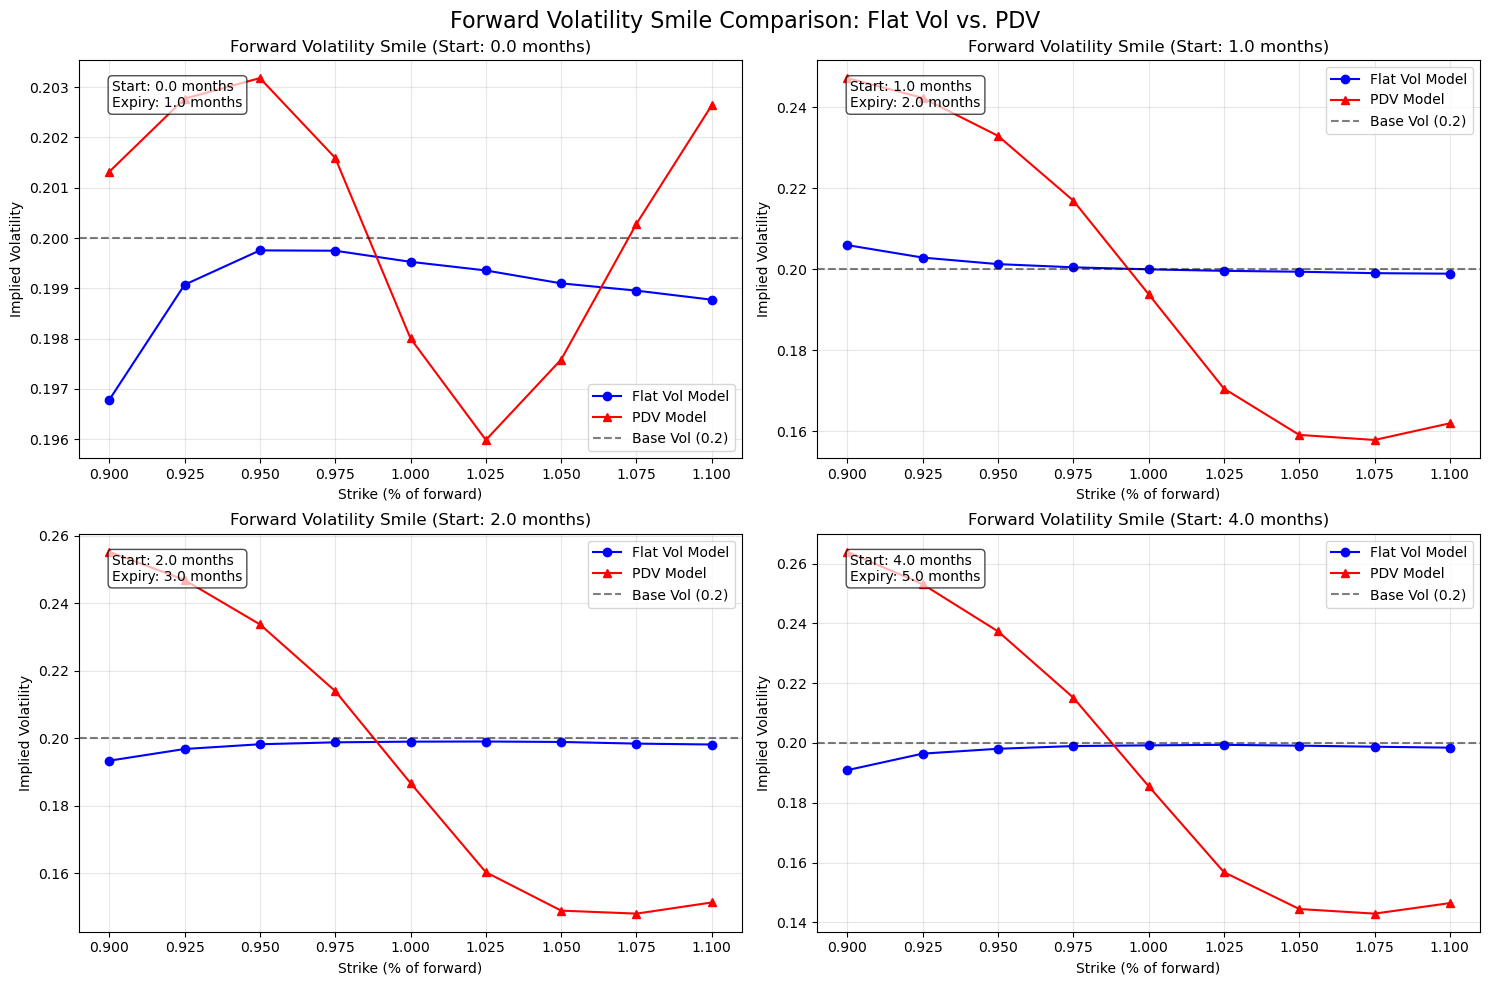

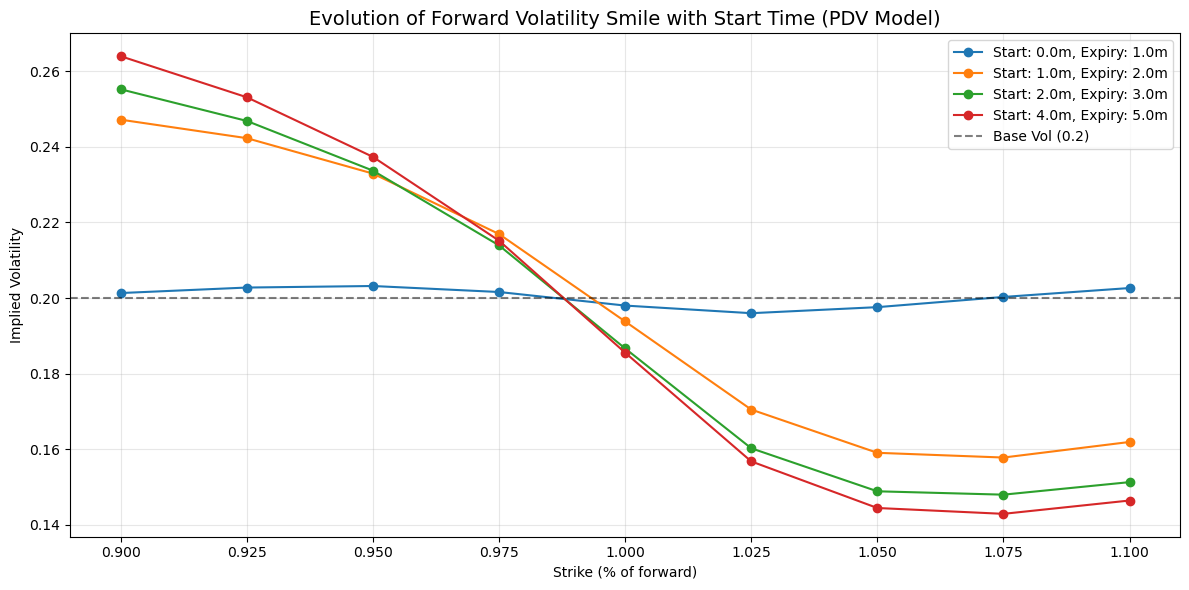

In [9]:
# Define parameters for forward volatility smile analysis
strike_percentages = np.linspace(0.9, 1.1, 9)  # Range of strike percentages: 90% to 110% of forward price
start_times = [0, 1/12, 1/6, 1/3]  # Start times: 0, 1, 2, and 4 months
expiry_offset = 1/12  # 1 month after start time
option_type = 'call'  # Focus on call options for the smile

# Dictionary to store implied volatilities
smile_results = {
    'Flat Vol': {},
    'PDV': {}
}

# Calculate forward prices and implied volatilities for each model and start time
for start_time in start_times:
    expiry = start_time + expiry_offset
    
    # Store implied volatilities for this start time
    smile_results['Flat Vol'][start_time] = []
    smile_results['PDV'][start_time] = []
    
    # Calculate option prices and implied vols across strikes
    for strike_pct in strike_percentages:
        # Price with flat vol model
        flat_price = mc_flat_vol.price_forward_start(option_type, strike_pct, start_time, expiry)
        
        # Price with PDV model
        pdv_price = mc_pdv.price_forward_start(option_type, strike_pct, start_time, expiry)
        
        # Calculate implied volatility using Black-Scholes formula
        # For forward start options, we use forward price = 1.0 since strikes are relative
        # and time-to-expiry is the difference between expiry and start time
        flat_iv = implied_volatility(
            flat_price['price'], 1.0, strike_pct, expiry_offset, 
            risk_free_rate, dividend_yield, option_type
        )
        
        pdv_iv = implied_volatility(
            pdv_price['price'], 1.0, strike_pct, expiry_offset, 
            risk_free_rate, dividend_yield, option_type
        )
        
        # Store results
        smile_results['Flat Vol'][start_time].append(flat_iv)
        smile_results['PDV'][start_time].append(pdv_iv)
    
    # Convert lists to numpy arrays for easier manipulation
    smile_results['Flat Vol'][start_time] = np.array(smile_results['Flat Vol'][start_time])
    smile_results['PDV'][start_time] = np.array(smile_results['PDV'][start_time])

# Visualize the forward volatility smiles
plt.figure(figsize=(15, 10))

# Create a 2x2 grid of plots for different start times
for i, start_time in enumerate(start_times):
    plt.subplot(2, 2, i+1)
    
    # Plot implied volatility curves for both models
    plt.plot(strike_percentages, smile_results['Flat Vol'][start_time], 
             'b-o', label='Flat Vol Model')
    plt.plot(strike_percentages, smile_results['PDV'][start_time], 
             'r-^', label='PDV Model')
    
    # Add horizontal line at the flat volatility level for reference
    plt.axhline(y=flat_vol, color='k', linestyle='--', alpha=0.5, 
                label=f'Base Vol ({flat_vol})')
    
    # Set labels and title
    plt.title(f'Forward Volatility Smile (Start: {start_time*12:.1f} months)', fontsize=12)
    plt.xlabel('Strike (% of forward)')
    plt.ylabel('Implied Volatility')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add text with start and expiry times
    expiry = start_time + expiry_offset
    plt.annotate(
        f'Start: {start_time*12:.1f} months\nExpiry: {expiry*12:.1f} months', 
        xy=(0.05, 0.95), xycoords='axes fraction',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
        verticalalignment='top'
    )

plt.tight_layout()
plt.suptitle('Forward Volatility Smile Comparison: Flat Vol vs. PDV', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

# Create a separate plot to show how the volatility smile evolves with forward start time
plt.figure(figsize=(12, 6))

# Plot PDV model smiles for different start times
for start_time in start_times:
    expiry = start_time + expiry_offset
    label = f'Start: {start_time*12:.1f}m, Expiry: {expiry*12:.1f}m'
    plt.plot(strike_percentages, smile_results['PDV'][start_time], 
             marker='o', label=label)

# Reference flat volatility
plt.axhline(y=flat_vol, color='k', linestyle='--', alpha=0.5, 
            label=f'Base Vol ({flat_vol})')

plt.title('Evolution of Forward Volatility Smile with Start Time (PDV Model)', fontsize=14)
plt.xlabel('Strike (% of forward)')
plt.ylabel('Implied Volatility')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()